<a href="https://www.kaggle.com/maulberto3/flowers-5-class-pytorch-cnn?scriptVersionId=89514105" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from pprint import pprint
from collections import defaultdict, OrderedDict
from random import choice, seed, randint
from tqdm import tqdm
from itertools import repeat, product, combinations, cycle
from pathlib import Path
from string import ascii_lowercase

import numpy as np
import pandas as pd

from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch import (load, amax as pt_amax, max as pt_max, ones, save, no_grad, stack, numel, tensor, 
                   manual_seed, sigmoid, tanh, add, mul, sub, div, amin as pt_amin, cat,
                  maximum, minimum, device, cuda, rand, prod, median, log as pt_log, round as pt_round,
                  isnan, flatten, mean, as_tensor)
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
#from torchviz import make_dot
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
device = device("cuda" if cuda.is_available() else "cpu")
# device = "cpu"
print("==> Device:", device)

==> Device: cuda


In [4]:
class NET(nn.Module):
    def __init__(self, 
                 batch_size,
                 params={
                     'image_r_crop': 64,
                     #
                    'feature_maps': 10, 
                    'f_kernel_size': 3, 
                    'f_pad_size': 0,
                    'pools': 'AvgPool2d', 
                    'p_kernel_size': 1, 
                    'f_activs': 'Softsign',
                     #
                    'f_kernel_size_h': 4, 
                    'f_pad_size_h': 0,
                    'pools_h': 'MaxPool2d', 
                    'p_kernel_size_h': 3, 
                    'f_activs_h': 'ELU',
                    'times_hidden': 5,
                 },
                 outputs_dim=5,
                ):
        super().__init__()
        
        self.batch_size = batch_size
        self.image_r_crop = params['image_r_crop']
        
        # inputs model
        self.f_maps = params['feature_maps']
        self.f_k_size = params['f_kernel_size']
        self.f_pad_size = params['f_pad_size']
        self.pool = params['pools']
        self.p_k_size = params['p_kernel_size']
        self.f_activs = params['f_activs']
        
        # hidden model
        self.f_k_size_h = params['f_kernel_size_h']
        self.f_pad_size_h = params['f_pad_size_h']
        self.pool_h = params['pools_h']
        self.p_k_size_h = params['p_kernel_size_h']
        self.f_activs_h = params['f_activs_h']
        self.times_hidden = params['times_hidden']
        
        # outputs model
        self.outputs_dim = outputs_dim  
        
        self.inputs_model = nn.Sequential(
            nn.Conv2d(3, 
                      self.f_maps, 
                      self.f_k_size, 
                      padding=(self.f_pad_size, self.f_pad_size),
                      padding_mode='reflect'),
            nn.Dropout2d(p=0.25),
            nn.__getattribute__(self.f_activs)(),
            nn.__getattribute__(self.pool)(kernel_size=self.p_k_size, 
                                           stride=1))
        
        self.hidden_model = nn.Sequential(
            nn.Conv2d(self.f_maps, 
                      self.f_maps, 
                      self.f_k_size_h, 
                      padding=(self.f_pad_size_h, self.f_pad_size_h),
                      padding_mode='reflect'),
            nn.Dropout2d(p=0.25),
            nn.__getattribute__(self.f_activs_h)(),
            nn.__getattribute__(self.pool_h)(kernel_size=self.p_k_size_h, 
                                             stride=1))
        
        self.hidden_models = nn.ModuleList([self.hidden_model for _ in range(self.times_hidden)])
        
        self._hiddens_to_output_helper()
                
        self.output_model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.hiddens_out.shape[1], self.outputs_dim),
            nn.Softmax(dim=-1)
        )
        
    def _hiddens_to_output_helper(self):
        self.hiddens_out = self.inputs_model(ones(self.batch_size,3,self.image_r_crop,self.image_r_crop))
        reprs = []
        for lay in self.hidden_models:
            reprs.append(lay(self.hiddens_out))
        self.hiddens_out = nn.Flatten()(cat(reprs, dim=-1))
        
    def forward(self, x):
        """Forward"""
        res = self.inputs_model(x)
        reprs = []
        for lay in self.hidden_models:
            reprs.append(lay(res))
        res = cat(reprs, dim=-1)
        res = self.output_model(res)
        return res
    
    def count_weights_biases(self):
        return int(sum(p.numel() for p in self.parameters() if p.requires_grad))
    
#net = NET(batch_size=16).train()
#print(f'forward: {net(ones(16, 3, 64, 64).float()).shape}')

In [5]:
# Data
trans = transforms.Compose([
            transforms.Resize(size=(80,80)), 
            # transforms.RandomRotation(degrees=[-5, 5], ),
            transforms.RandomCrop(size=(64,64)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
image_folder = ImageFolder('/kaggle/input/flower-photos-by-the-tensorflow-team/flower_photos', 
                    transform=trans)

# Net
net = NET(batch_size=64)
net = net.to(device)

# Optimizer
optimizer = Adam(net.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

# Train
#train_ds = DS(X_train, y_train)  # TODO refactor out
train_dl = DataLoader(image_folder,
                    batch_size=64,
                    shuffle=True,
                    num_workers=2,
                    drop_last=True)

for epoch in range(50):
    #running_loss = []
    train_correct = 0
    train_total = 0
    for i, (inputs, labels) in enumerate(train_dl):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        outputs = pt_log(outputs)

        optimizer.zero_grad()
        loss = criterion(outputs, labels).mean()
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss.append(loss.item())
        _, predicted = pt_max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_accuracy = train_correct / train_total * 100
    print(f'TRAIN {train_accuracy:^4.2f} %', end=' ')

TRAIN 37.72 % TRAIN 42.43 % TRAIN 45.04 % TRAIN 46.19 % TRAIN 46.66 % TRAIN 48.46 % TRAIN 48.60 % TRAIN 49.59 % TRAIN 48.33 % TRAIN 49.73 % TRAIN 49.53 % TRAIN 50.11 % TRAIN 51.23 % TRAIN 51.26 % TRAIN 51.59 % TRAIN 51.54 % TRAIN 52.96 % TRAIN 52.85 % TRAIN 53.10 % TRAIN 53.62 % TRAIN 52.91 % TRAIN 55.07 % TRAIN 54.41 % TRAIN 55.18 % TRAIN 54.85 % TRAIN 54.91 % TRAIN 55.81 % TRAIN 55.65 % TRAIN 56.25 % TRAIN 56.09 % TRAIN 56.50 % TRAIN 56.20 % TRAIN 56.30 % TRAIN 57.37 % TRAIN 57.43 % TRAIN 56.50 % TRAIN 56.91 % TRAIN 56.69 % TRAIN 57.21 % TRAIN 57.65 % TRAIN 58.36 % TRAIN 57.76 % TRAIN 57.59 % TRAIN 56.25 % TRAIN 57.15 % TRAIN 58.61 % TRAIN 58.25 % TRAIN 56.44 % TRAIN 59.13 % TRAIN 59.16 % 

Net Improvement with latest from-scratch nn architecture>: ~+4%, i.e. ~55% to ~59%.

### TODO

- Make test and train sets
- Try image rotation and other transforms
- Try more/less image resize and other transforms
- Try make the net bigger (done with times_hidden as ModuleList)
- Review quality of data/images (this is crucial, the better the data, the better the model)

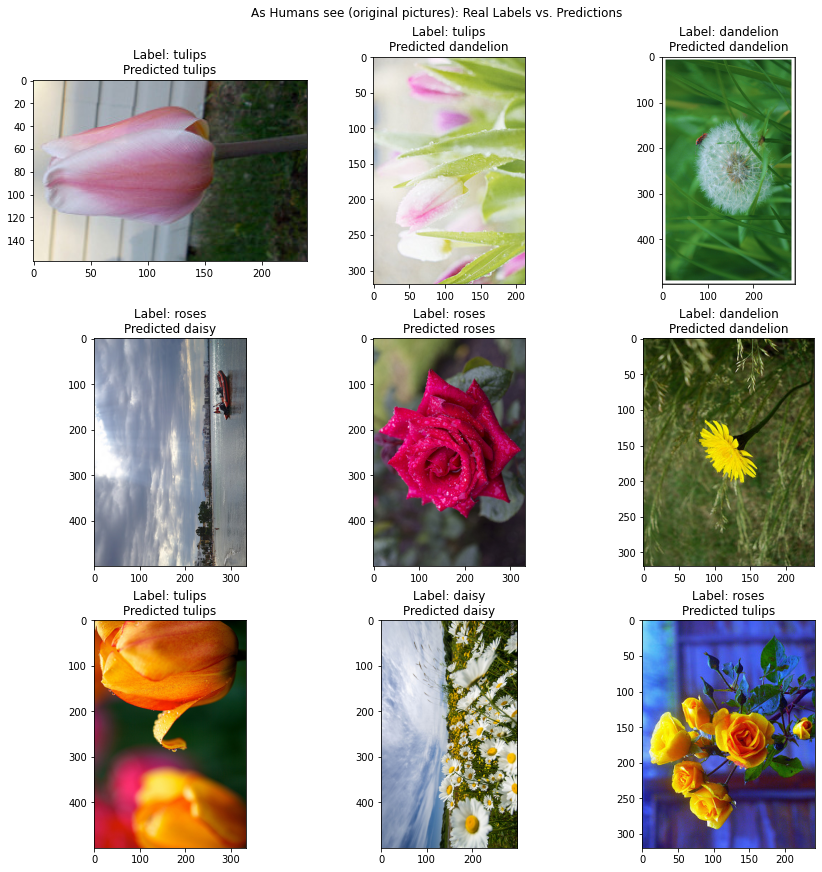

In [6]:
# Analyze Labels vs Predictions
trans_ = transforms.Compose([ transforms.ToTensor() ])
image_folder_ = ImageFolder('/kaggle/input/flower-photos-by-the-tensorflow-team/flower_photos', transform=trans_)

flowers = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

fig, ax = plt.subplots(3,3, figsize=(12,12), constrained_layout=True)
ax = ax.flatten()
nums = [randint(0, len(image_folder)) for num in range(9)]
preds = [net(image_folder[num][0].unsqueeze(dim=0).cuda()).argmax().item() for num in nums]

for ax, num, pred in zip(ax, nums, preds):
    img_ = image_folder_[num]
    _ = ax.imshow(img_[0].swapaxes(0,-1))
    _ = ax.set_title(f'Label: {flowers[img_[1]]}\nPredicted {flowers[pred]}')
_ = fig.suptitle('As Humans see (original pictures): Real Labels vs. Predictions')


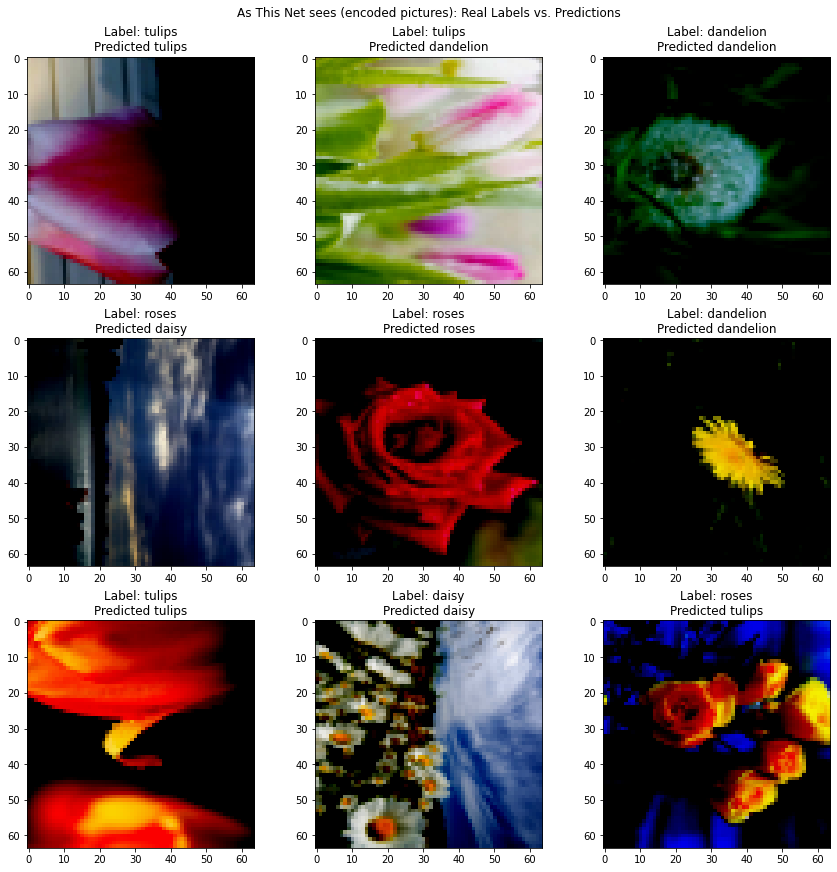

In [7]:
fig, ax = plt.subplots(3,3, figsize=(12,12), constrained_layout=True)
ax = ax.flatten()

for _, ax, num, pred in zip(range(9), ax, nums, preds):
    img = image_folder[num]
    _ = ax.imshow(img[0].swapaxes(0,-1))
    _ = ax.set_title(f'Label: {flowers[img[1]]}\nPredicted {flowers[pred]}')
_ = fig.suptitle('As This Net sees (encoded pictures): Real Labels vs. Predictions')

,0,1,2
647,0.999300,3.0,1.0
989,0.993204,3.0,1.0
1286,0.989422,3.0,1.0
1553,0.971254,4.0,2.0
825,0.971233,3.0,1.0
1283,0.953824,3.0,1.0
1055,0.947048,3.0,1.0
77,0.943713,2.0,0.0
1056,0.940322,3.0,1.0


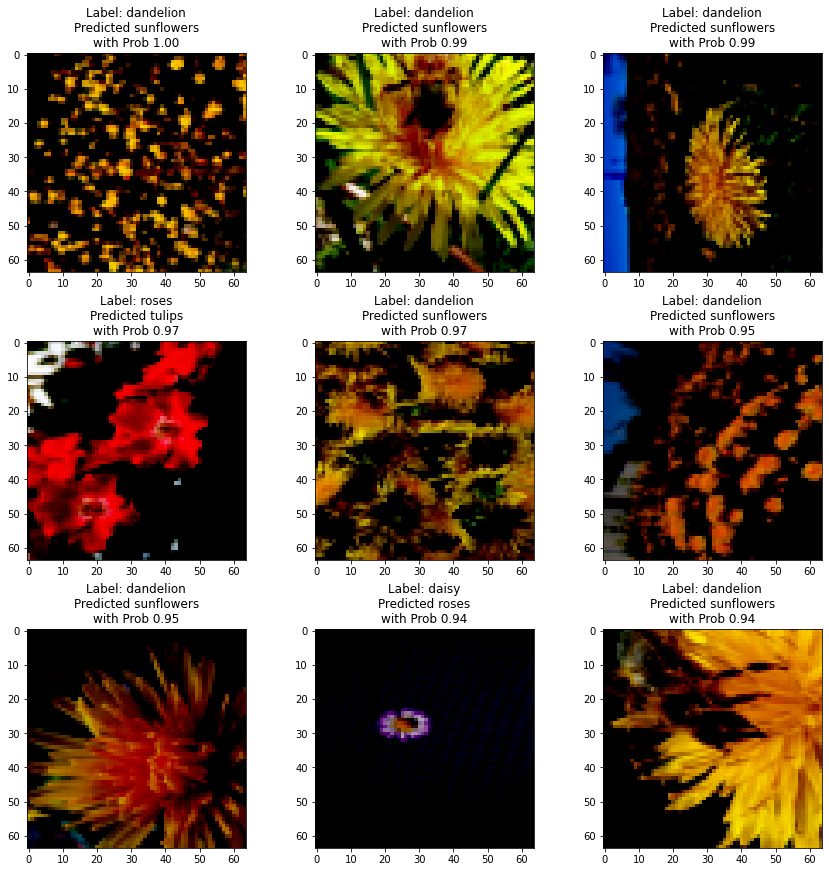

In [8]:
# Worst predictions Analysis

# High probability, but they where False Positives!
whole_dataset = DataLoader(image_folder,
                    batch_size=len(image_folder)//2,
                    #shuffle=True,
                    num_workers=1,
                    drop_last=True
                          )

whole_dataset = iter(whole_dataset)
whole_dataset = next(whole_dataset)
images, labels = whole_dataset[0], whole_dataset[1]

inputs = images.to(device)
outputs = net(inputs)

worst_preds = stack([outputs.max(dim=1)[0], outputs.argmax(dim=1), labels.cuda()])  # pred_prob, pred, label
worst_preds = worst_preds.T
worst_preds = worst_preds.cpu().detach().numpy()
worst_preds = pd.DataFrame(worst_preds).sort_values(by=0, ascending=False)
mask = worst_preds.iloc[:, 1] == worst_preds.iloc[:, 2]
worst_preds = worst_preds[~mask]
worst_preds = worst_preds.iloc[:9, :]
worst_preds

fig, ax = plt.subplots(3,3, figsize=(12,12), constrained_layout=True)
ax = ax.flatten()

for ax, num, label, pred, pred_prob in zip(ax, 
                                    worst_preds.index, 
                                    worst_preds.iloc[:, 2].astype(int),
                                    worst_preds.iloc[:, 1].astype(int),
                                    worst_preds.iloc[:, 0], 
                                    
                                   ):
    img = images[num]
    _ = ax.imshow(img.swapaxes(0,-1))
    _ = ax.set_title(f'Label: {flowers[label]}\nPredicted {flowers[pred]}\nwith Prob {pred_prob:.2f}')  # with {pred_prob:.2f}')
#_ = fig.suptitle('As This Net sees (encoded pictures): Real Labels vs. Predictions')

In [9]:
### DISCUSSION
# Some flowers resemble other, i.e. tulips with roses, closed daisies with dandelions...
# I think there are some clear mis-labels...
# There are even images with animals and no flowers, ie. a dove!
# There seemns to be mixed flowers in some images...